# Introduction

In this notebook, we will look at how hierarchical models can help us in scenarios where we do not have sufficient data to meaningfully quantify our uncertainties. By making assumptions about relatedness, we can borrow statistical power from other observations, 

In [1]:
import pandas as pd
import janitor as jn
import pymc3 as pm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
df = pd.read_csv('../data/finch_beaks_2012.csv')
df = (jn.DataFrame(df)
      .clean_names()
      .rename_column('blength', 'beak_length')
      .rename_column('bdepth', 'beak_depth')
      .encode_categorical('species')
     )
df.groupby('species').size()

species
fortis      121
scandens    127
unknown       1
dtype: int64

In [21]:
df.groupby('species')['beak_depth'].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
fortis,121.0,8.605372,0.732570,7.2,8.1,8.5,9.0,11.1
scandens,127.0,9.186220,0.669241,7.7,8.8,9.2,9.6,11.0
unknown,1.0,6.800000,NaN,6.8,6.8,6.8,6.8,6.8


In [22]:
fortis_filter = df['species'] == 'fortis'
scandens_filter = df['species'] == 'scandens'
unknown_filter = df['species'] == 'unknown'

In [24]:
def enc_species(x):
    if x == 'fortis':
        return 0
    if x == 'scandens':
        return 1
    else:
        return 2

In [25]:
df['species_enc'] = df['species'].apply(lambda x: enc_species(x))
df['species_enc'].head(5)

0    0
1    0
2    0
3    0
4    0
Name: species_enc, dtype: category
Categories (3, int64): [0, 1, 2]

In [39]:
with pm.Model() as beak_depth_model:
    sd_prior = pm.HalfCauchy('sd_prior', beta=100)
    beta_prior = pm.HalfCauchy('beta_prior', beta=100)
    
    finches_mean = pm.HalfNormal('finches_mean', sd=sd_prior, shape=(3,))
    finches_sd = pm.HalfCauchy('finches_sd', beta=beta_prior, shape=(3,))
    
    fortis_mean = pm.Deterministic('fortis_mean', finches_mean[df[fortis_filter]['species_enc']])
    scandens_mean = pm.Deterministic('scandens_mean', finches_mean[df[scandens_filter]['species_enc']])
    
    fortis_sd = pm.Deterministic('fortis_sd', finches_sd[df[fortis_filter]['species_enc']])
    scandens_sd = pm.Deterministic('scandens_sd', finches_sd[df[scandens_filter]['species_enc']])
    
    unknown_mean = pm.Deterministic('unknown_mean', finches_mean[df[unknown_filter]['species_enc']])
    unknown_sd = pm.Deterministic('unknown_sd', finches_sd[df[unknown_filter]['species_enc']])
    
    nu = pm.Exponential('nu', lam=1/29.) + 1
    
    like_fortis = pm.StudentT('like_fortis', mu=fortis_mean, sd=fortis_sd, nu=nu,
                              observed=df[fortis_filter]['beak_depth'])
    like_scandens = pm.StudentT('like_scandens', mu=scandens_mean, sd=scandens_sd, nu=nu,
                                 observed=df[scandens_filter]['beak_depth'])
    like_unknown = pm.StudentT('like_unknown', mu=unknown_mean, sd=unknown_sd, nu=nu,
                               observed=df[unknown_filter]['beak_depth'])

In [42]:
with beak_depth_model:
    trace = pm.sample(2000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_log__, finches_sd_log__, finches_mean_log__, beta_prior_log__, sd_prior_log__]
100%|██████████| 2500/2500 [02:55<00:00, 14.24it/s]
The number of effective samples is smaller than 25% for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c20a68208>,
      dtype=object)

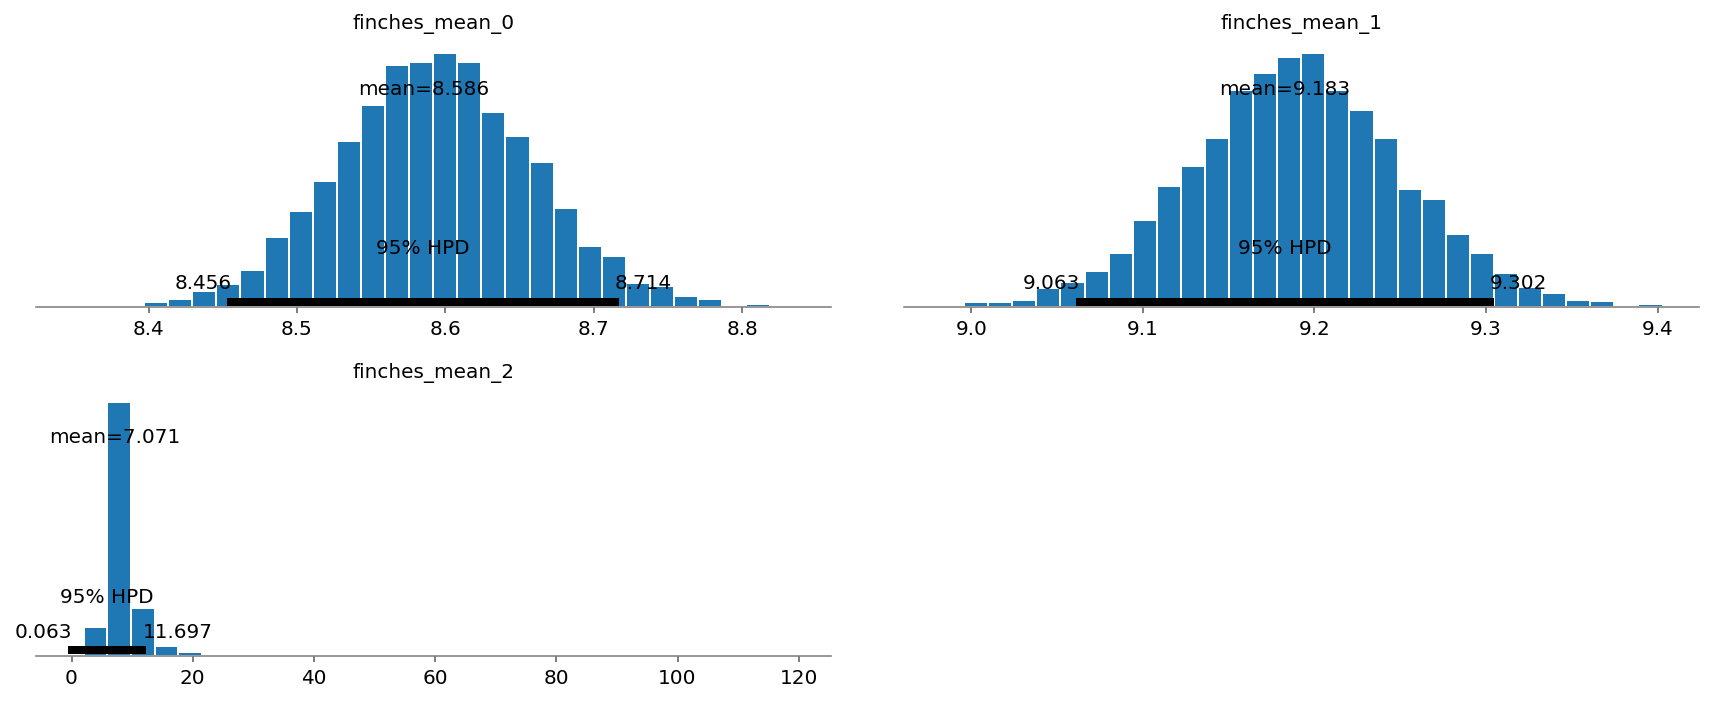

In [44]:
pm.plot_posterior(trace, varnames=['finches_mean'], )